# Natural Language Processing with Disaster Tweets - Kaggle Competition
In this project, the aim to classify tweets as either disaster-related or not.
### Project Repository
Full project repository on GitHub: [Disaster Tweet Classification](https://github.com/2salmans24/Disaster-Tweet-Classification/tree/main)
#### This notebook outlines the following steps:
1. Problem and Data Description
2. Exploratory Data Analysis (EDA)
3. Text Preprocessing and Embedding
4. Model Architecture and Training
5. Results Analysis and Conclusion


In [1]:
!pip install seaborn
!pip install numpy==1.24.0 scipy==1.10.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 69.0 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.0
    Uninstalling numpy-1.24.0:
      Successfully uninstalled numpy-1.24.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
catboost 1.2.7 requires numpy<2.0,>=1.16.0, but you have numpy 2.1.3 which is incompatible.
numba 0.55.2 requires numpy<1.23,>=1.18, but you have numpy 2.1.3 which is incompatible.
scipy 1.10.0 requires numpy<1.27.0,>=1.19.5, but you have numpy 2.1.3 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.1.3 which is incompatible.
tensorflow-rocm 2.16.1 requires ml-dtypes~=0.3.1, but you have ml-dtypes 0.4.1 which is incompatible.
tensorflow-rocm 2.16.1 requires numpy<2.0.0,>=1.23.5; python_version <= "3.11", but you have numpy 2.1.3 which is

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'  # Suppress info and warnings
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


NameError: name 'tf' is not defined

In [3]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
import re


2024-11-09 05:29:37.540856: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731130177.550203    3127 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731130177.552863    3127 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Exploratory Data Analysis (EDA),
### Loading the Dataset
I'll load the train and test datasets.


In [4]:
# Load datasets
train_data = pd.read_csv('/container_data/train.csv')
test_data = pd.read_csv('/container_data/test.csv')

train_data.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Quick Look at the Data
checking the structure of the training and test data to understand the available features and data types.


In [5]:
# Display information about the datasets
print("Train Data Info:")
print(train_data.info())
print("\nTrain Data Sample:")
print(train_data.head())

print("\nTest Data Info:")
print(test_data.info())
print("\nTest Data Sample:")
print(test_data.head())


Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None

Train Data Sample:
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  

### Data Overview and Observations
The dataset contains 7,613 training entries and 3,263 test entries, with columns `id`, `keyword`, `location`, `text`, and `target` (in the training set). The `text` column holds the tweet content, which we will use as the primary feature for classification. Notably, the `keyword` and `location` columns have substantial missing values, which we may ignore for this initial analysis. The `target` variable is binary, indicating whether a tweet is disaster-related.


### Class Distribution
I'll visualize the distribution of the `target` variable to check if there is any class imbalance. This helps to understand if there are more tweets labeled as disaster (1) or non-disaster (0), which may affect model training.


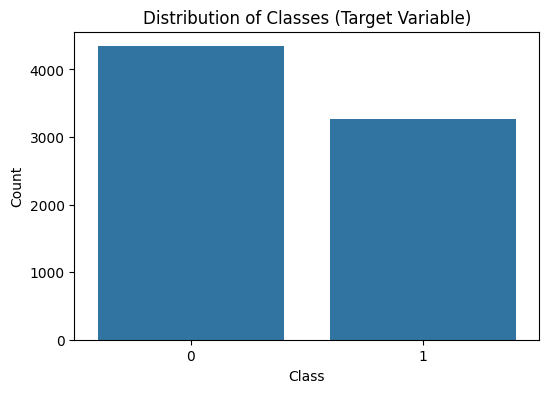

In [6]:
# Plot class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=train_data)
plt.title('Distribution of Classes (Target Variable)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


## The class distribution plot shows that there is a slight imbalance in the target variable:
Class 0 (non-disaster tweets) has a slightly higher count than Class 1 (disaster-related tweets).
This imbalance is not extreme, so it likely won't require significant adjustments like oversampling or undersampling. that said, it’s worth looking out as it could still slightly affect the model's performance, especially if the model tends to favor the majority class.

### Text Length Distribution
We analyze the length of each tweet in the `text` column. This information can help identify any outliers in tweet length and guide decisions on input length for the model.


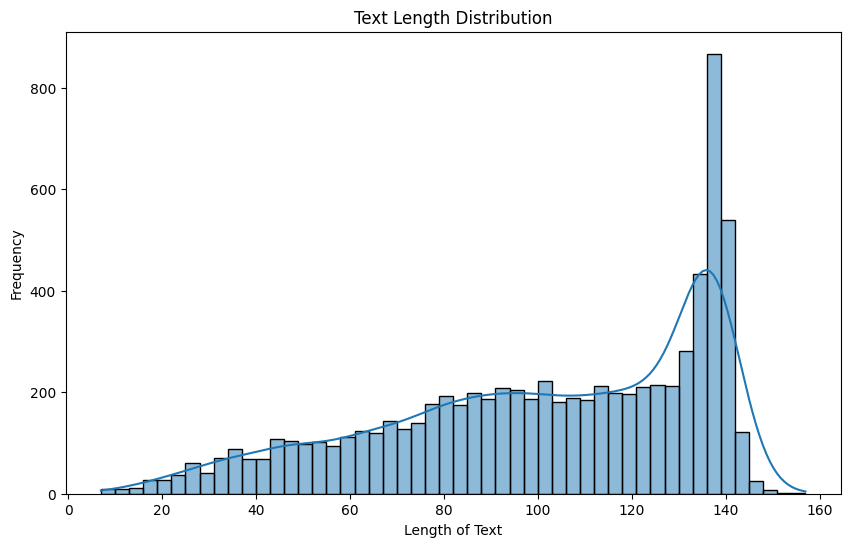

In [7]:
# Adding a column for text length in the training data
train_data['text_length'] = train_data['text'].apply(len)

# Plotting the distribution of text length
plt.figure(figsize=(10, 6))
sns.histplot(train_data['text_length'], bins=50, kde=True)
plt.title('Text Length Distribution')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.show()


### Text Length Distribution Analysis

The histogram above illustrates the distribution of tweet lengths within the dataset. Key observations include:

1. **Distribution Shape**:
   - The distribution of tweet lengths is slightly right-skewed, with a significant concentration of tweets having lengths between 100 and 140 characters. This peak near 140 characters aligns with Twitter's former character limit, indicating that many users utilize the maximum space available when tweeting.

2. **Implications for Model Training**:
   - The consistency in tweet length means that models like Dense Neural Networks, which do not require sequence-based padding, can handle the input effectively. This also simplifies text processing for token-based embeddings (e.g., TF-IDF), as there’s minimal variation in input size.
   
3. **Considerations for Sequence Models**:
   - If we were to use a sequential model (e.g., RNN, LSTM), we could standardize the input length to around 140 characters to cover the majority of tweets without significant truncation or excessive padding. This approach would help maintain the integrity of the text while ensuring uniform input sizes for the model.

Overall, the length distribution suggests that a significant portion of tweets falls within a manageable character range, supporting the choice of both TF-IDF and word-based embeddings.


### Text Cleaning
To prepare the tweets for modeling, we clean the text by removing special characters, punctuation, and excess whitespace. We also lowercase all text to ensure consistency.


In [8]:
# Define a function to clean the text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove non-word characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespace
    return text.strip()

# Apply preprocessing to the text in train and test sets
train_data['clean_text'] = train_data['text'].apply(preprocess_text)
test_data['clean_text'] = test_data['text'].apply(preprocess_text)


### Text Embedding with TF-IDF
We convert the cleaned text into numerical format using TF-IDF (Term Frequency-Inverse Document Frequency). TF-IDF gives more weight to words that are unique to each tweet while reducing the weight of common words, making it suitable for this classification task.


In [9]:
# TF-IDF Vectorization on the clean text
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(train_data['clean_text']).toarray()
y = train_data['target']  # Target labels


### Train-Test Split
Split the data into training and validation sets.
The validation set will help evaluate model performance on unseen data,this will give an idea of how well the model generalizes.


In [10]:
# Splitting data for training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


### Model Architecture and Embedding Choice

#### I. Model Architecture and Reasoning

For this text classification problem, I chose a **Dense Neural Network** architecture with fully connected layers. The model is structured as follows:

1. **Input Layer**:
   - The model takes TF-IDF transformed vectors as input, which represent the tweets in numerical form. The input shape matches the number of TF-IDF features (5,000 in this case).

2. **Hidden Layers**:
   - **Dense Layers** with ReLU activation: Two dense layers with 128 and 64 neurons respectively help the model learn high-level, non-linear relationships between TF-IDF features. ReLU (Rectified Linear Unit) activation is used to introduce non-linearity, which allows the network to model complex patterns.
   - **Dropout Layers**: To mitigate overfitting, I incorporated dropout layers with a 50% dropout rate after each dense layer. Dropout works by randomly disabling a fraction of neurons during each training iteration, which forces the model to learn more robust and generalized features.

3. **Output Layer**:
   - A single neuron with Sigmoid activation outputs a probability between 0 and 1, representing the likelihood that a tweet is disaster-related. This is ideal for binary classification, as it allows the model to produce a clear decision boundary for each tweet.

**Reasoning**:
- The choice of a Dense Neural Network is based on the TF-IDF representation of text, which provides fixed-length feature vectors for each tweet. Since the TF-IDF vectors do not retain sequential information, using recurrent layers (e.g., LSTM or GRU) is not necessary. Dense layers can effectively learn from these fixed-length vectors and make them a good fit for this model.
- Dropout layers are included to reduce overfitting, especially given the relatively small dataset size.

---

#### II. Word Embedding Choice

For this task, I used **TF-IDF (Term Frequency - Inverse Document Frequency)** to convert the text data into numerical form. TF-IDF is a simple yet effective embedding method, especially for short text classification, such as tweets. Here’s an overview of TF-IDF and other common embedding methods:

1. **TF-IDF (Term Frequency - Inverse Document Frequency)**:
   - TF-IDF represents each word's relevance in a document relative to its overall occurrence across all documents. It has two components:
     - **Term Frequency (TF)**: Measures the frequency of each word within a specific document.
     - **Inverse Document Frequency (IDF)**: Weights each word inversely to its frequency across all documents, so commonly used words (e.g., "the," "is") receive lower scores.
   - **Reasoning**: TF-IDF highlights unique, informative words that differentiate disaster-related tweets from non-disaster tweets. It’s computationally efficient, making it suitable for initial model iterations.

2. **Alternative Embeddings**:
   - **GloVe (Global Vectors for Word Representation)**:
     - GloVe is a pre-trained embedding that captures semantic relationships by training on a large corpus. It creates dense vector representations for words based on their co-occurrence, which captures global statistical information about words in the corpus.
     - **Usage**: GloVe could be beneficial for tasks where understanding word context and relationships is essential. It is commonly used in conjunction with sequential models, like LSTMs or GRUs.
   
   - **Word2Vec**:
     - Word2Vec also creates dense embeddings by training words in context, capturing the similarity between words based on their surrounding words. Word2Vec embeddings are often used with RNNs to provide a deeper understanding of context in text data.
     - **Usage**: Similar to GloVe, Word2Vec embeddings are beneficial for longer or complex texts where context provides additional meaning. They are also effective when paired with sequential models.

In summary, **TF-IDF** was chosen due to its simplicity and effectiveness in representing short text data. If future iterations require capturing contextual relationships in tweets, **GloVe** or **Word2Vec** embeddings with an RNN-based architecture (e.g., LSTM or GRU) could be explored.

---

#### III. References
- Vector space model, Wikipedia
- Matrices, Vector Spaces, andInformation Retrieval; Michael W. Berry, Zlatko Drmac, Elizabeth R. Jessup
- Pennington, J., Socher, R., & Manning, C. D. (2014). **GloVe: Global Vectors for Word Representation**. In *Proceedings of the 2014 Conference on Empirical Methods in Natural Language Processing (EMNLP)*.
- Mikolov, T., Chen, K., Corrado, G., & Dean, J. (2013). **Efficient Estimation of Word Representations in Vector Space**. arXiv preprint arXiv:1301.3781.


### Model Building and Compilation
I'll construct a simple dense neural network with two hidden layers, each followed by dropout to prevent overfitting. The model is compiled with the Adam optimizer and binary cross-entropy loss, suitable for binary classification.


In [ ]:
!pip install -U optree


In [ ]:
!pip install -U tensorflow

In [ ]:
!pip install -U keras


In [12]:
from tensorflow.keras import Input

# Rebuilding the model with Input layer
model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Explicit input layer
    Dense(128, activation='relu'),
    Dropout(0.5),  # Dropout to prevent overfitting
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model architecture
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │       640,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 648,449 (2.47 MB)

 Trainable params: 648,449 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

##### The summary indicates that the architecture has been correctly defined, there are two hidden dense layers, The first dense layer has 128 units and requires 640,128 parameters. The second dense layer has 64 units and requires 8,256 parameters.


#### Next...
- Train the Model with using training data (X_train and y_train) to train the model.
- Set up validation data (X_val and y_val) to monitor performance on unseen data during training.


In [14]:
# Training the model for a few epochs
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), batch_size=64)


Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5760 - loss: 0.6725 - val_accuracy: 0.7938 - val_loss: 0.5226
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8211 - loss: 0.4404 - val_accuracy: 0.7997 - val_loss: 0.4596
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8843 - loss: 0.3025 - val_accuracy: 0.8004 - val_loss: 0.4800
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9165 - loss: 0.2267 - val_accuracy: 0.7899 - val_loss: 0.5171
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9342 - loss: 0.1849 - val_accuracy: 0.7761 - val_loss: 0.5901


In [15]:
# Predicting on the validation data
y_pred = (model.predict(X_val) > 0.5).astype("int32")

# Evaluating model performance
print("Validation Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step
Validation Accuracy: 0.7760998030203545
              precision    recall  f1-score   support

           0       0.81      0.80      0.80       874
           1       0.74      0.74      0.74       649

    accuracy                           0.78      1523
   macro avg       0.77      0.77      0.77      1523
weighted avg       0.78      0.78      0.78      1523



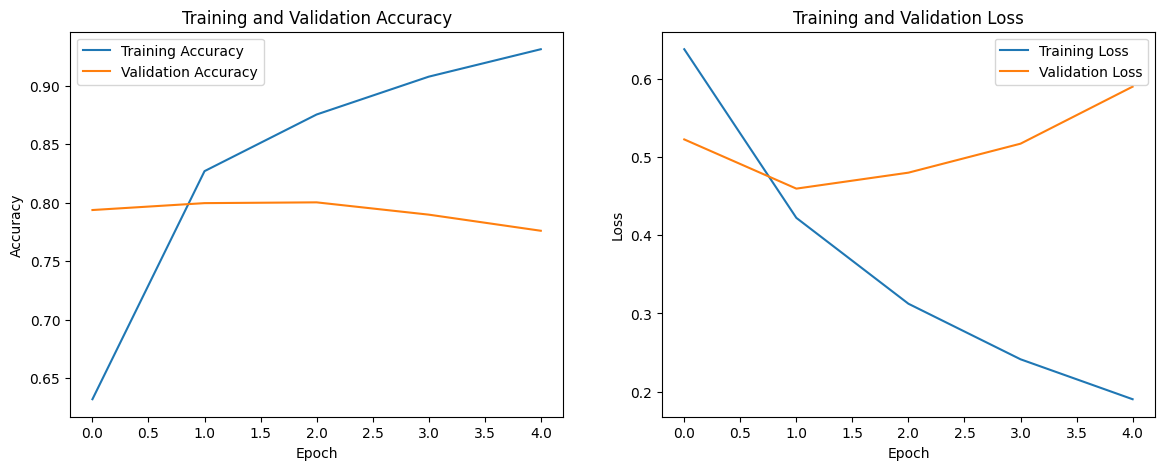

In [16]:
# Plot training and validation accuracy and loss
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


The training and validation curves indicate a common issue with overfitting. Here’s a breakdown of the plots:

Training and Validation Accuracy:

The training accuracy continues to improve with each epoch, approaching close to 0.9.
However, the validation accuracy plateaus around 0.8 and even begins to decrease slightly by the end of training. This suggests that the model is learning patterns in the training data but not generalizing well to new data.
Training and Validation Loss:

The training loss decreases steadily, indicating that the model is effectively minimizing the error on the training data.
However, the validation loss starts to increase after the initial epochs, which is a classic sign of overfitting. This means that the model is “memorizing” the training data instead of learning general patterns.

#### Automate the process of testing multiple configurations to find the best solution for reducing overfitting

In [19]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input
import numpy as np

# Define configurations to test
configurations = [
    {"dense_units": [128, 64], "dropout_rate": 0.5},
    {"dense_units": [64, 32], "dropout_rate": 0.5},
    {"dense_units": [64, 32], "dropout_rate": 0.6},
    {"dense_units": [32, 16], "dropout_rate": 0.5},
    {"dense_units": [32, 16], "dropout_rate": 0.6},
]

# Initialize variables to store the best configuration and performance
best_val_accuracy = 0
best_config = None
best_model = None

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Loop through each configuration
for config in configurations:
    print(f"Testing configuration: Dense units = {config['dense_units']}, Dropout rate = {config['dropout_rate']}")

    # Build the model for each configuration
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    for units in config['dense_units']:
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(config['dropout_rate']))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model with early stopping
    history = model.fit(
        X_train, y_train,
        epochs=20,
        validation_data=(X_val, y_val),
        batch_size=64,
        callbacks=[early_stopping],
        verbose=0  # Suppress output for clarity
    )

    # Evaluate the model on the validation set
    val_accuracy = max(history.history['val_accuracy'])
    print(f"Validation Accuracy: {val_accuracy:.4f}")

    # Check if this configuration is the best so far
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_config = config
        best_model = model

print("\nBest Configuration:")
print(f"Dense units: {best_config['dense_units']}, Dropout rate: {best_config['dropout_rate']}")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")


Testing configuration: Dense units = [128, 64], Dropout rate = 0.5
Validation Accuracy: 0.7965
Testing configuration: Dense units = [64, 32], Dropout rate = 0.5
Validation Accuracy: 0.8011
Testing configuration: Dense units = [64, 32], Dropout rate = 0.6
Validation Accuracy: 0.8083
Testing configuration: Dense units = [32, 16], Dropout rate = 0.5
Validation Accuracy: 0.8129
Testing configuration: Dense units = [32, 16], Dropout rate = 0.6
Validation Accuracy: 0.7991

Best Configuration:
Dense units: [32, 16], Dropout rate: 0.5
Best Validation Accuracy: 0.8129


### The programmatic hyperparameter search has successfully identified the best configuration:

Best Configuration Results
Dense Units: [32, 16]
Dropout Rate: 0.5
Best Validation Accuracy: 0.8129
This configuration uses fewer neurons in each layer and a moderate dropout rate, which seems to provide a good balance between model complexity and generalization ability.



In [21]:
# Save the model in the native Keras format
best_model.save('best_disaster_tweet_model.keras')


In [23]:
# Generate predictions on the test data
test_predictions = (best_model.predict(X_test) > 0.5).astype("int32")

# Prepare submission DataFrame
submission = pd.DataFrame({
    "id": test_data["id"],            # Use 'id' column from the test data
    "target": test_predictions.flatten()  # Flatten to ensure the correct shape
})

# Save the submission file as CSV
submission.to_csv("submission_W4.csv", index=False)
print("Submission file 'submission_W4.csv' has been created.")


102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step
Submission file 'submission_W4.csv' has been created.
